In [ ]:
#Tortured Bots Department - an attempt to train a small transformer model
#Dataset link: https://www.kaggle.com/datasets/madroscla/taylor-swift-released-song-discography-genius
#Attempt is to train a model on Taylor Swift's 11th Album "The Tortured Poets Department" lyrics
#And occasionally do some cringe in the name of documentation
#NOTE: The album contains explicit lyrics, so the model will be trained on the explicit version of the lyrics
#And the model will generate explicit lyrics

# Transformer-Based Lyric Generation: Technical Workflow

This notebook documents the end-to-end process of building, training, and evaluating a transformer model for lyric generation using Taylor Swift's discography (song lyrics of THE TORTURED POETS DEPARTMENT (Original Version and The Anthology)) as the dataset. The workflow includes data preprocessing, tokenization, model architecture, training with early stopping and learning rate scheduling, hyperparameter optimization, and model serialization.

## Data Loading

We begin by importing the dataset containing Taylor Swift's released song discography. The dataset includes metadata and lyrics for each track. We use pandas for efficient data manipulation and exploration.

In [2]:
import pandas as pd
main_df = pd.read_csv("ts_discography_released.csv")
main_df.head()

,album_title,album_url,category,album_track_number,song_title,song_url,song_artists,song_release_date,song_page_views,song_lyrics,song_writers,song_producers,song_tags
0,Taylor Swift,https://genius.com/albums/Taylor-Swift/Taylor-...,Taylor Swift,1,Tim McGraw,https://genius.com/Taylor-swift-tim-mcgraw-lyrics,['Taylor Swift'],2006-06-19,290200,"['He said the way my blue eyes shined', 'Put t...","['Liz Rose', 'Taylor Swift']",['Nathan Chapman'],"['Country', 'In English', 'USA', 'Country Rock..."
1,Taylor Swift,https://genius.com/albums/Taylor-Swift/Taylor-...,Taylor Swift,2,Picture to Burn,https://genius.com/Taylor-swift-picture-to-bur...,['Taylor Swift'],2006-10-24,292500,"[""State the obvious, I didn't get my perfect f...","['Liz Rose', 'Taylor Swift']",['Nathan Chapman'],"['Pop', 'Rock', 'Country', 'In English', 'USA'..."
2,Taylor Swift,https://genius.com/albums/Taylor-Swift/Taylor-...,Taylor Swift,3,Teardrops On My Guitar,https://genius.com/Taylor-swift-teardrops-on-m...,['Taylor Swift'],2006-10-24,258800,"['Drew looks at me', ""I fake a smile so he won...","['Liz Rose', 'Taylor Swift']",['Nathan Chapman'],"['Country', 'In English', 'USA', 'Adult Contem..."
3,Taylor Swift,https://genius.com/albums/Taylor-Swift/Taylor-...,Taylor Swift,4,A Place In This World,https://genius.com/Taylor-swift-a-place-in-thi...,['Taylor Swift'],2006-10-24,91400,"[""I don't know what I want, so don't ask me"", ...","['Angelo Petraglia', 'Robert Ellis Orrall', 'T...",['Nathan Chapman'],"['Country', 'Pop', 'In English', 'USA', 'Teen ..."
4,Taylor Swift,https://genius.com/albums/Taylor-Swift/Taylor-...,Taylor Swift,5,Cold as You,https://genius.com/Taylor-swift-cold-as-you-ly...,['Taylor Swift'],2006-10-24,148000,"['You have a way of coming easily to me', 'And...","['Liz Rose', 'Taylor Swift']",['Nathan Chapman'],"['Country', 'Pop', 'In English', 'USA', 'Balla..."


In [3]:
df = main_df[main_df['album_title'] == "THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY"]
df.shape

(31, 13)

## Data Preprocessing

The raw lyrics are stored as stringified lists. We convert these to plain text, concatenate all lyrics, and perform basic cleaning:
- Lowercasing all text
- Removing punctuation and special characters
- Collapsing multiple spaces

This ensures the input to the model is consistent and noise-free.

In [4]:
#Now our df has the songs from the main+anthology album. 
#Lets get on to making the dataset. 
# Extract the lyrics column and flatten each song's lyrics list into a string
import ast

# Convert the string representation of lists to actual lists, then join them
lyrics_list = df['song_lyrics'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# Combine all lyrics into one document
full_lyrics_document = '\n\n'.join(lyrics_list)

# Display a preview
print(full_lyrics_document[:1000])  # Show first 1000 characters

I was supposed to be sent away But they forgot to come and get me I was a functioning alcoholic 'Til nobody noticed my new aesthetic All of this to say I hope you're okay But you're the reason And no one here's to blame But what about your quiet treason? And for a fortnight there, we were forever Run into you sometimes, ask about the weather Now you're in my backyard, turned into good neighbors Your wife waters flowers, I wanna kill her [Verse 2: Taylor Swift,  Taylor Swift & Post Malone ,  Post Malone ] All my mornings are Mondays stuck in an  endless February I took the miracle move-on drug, the  effects were temporary And I love you, it's ruining my life I love you, it's ruining my life I touched you for only a fortnight I touched you , but I touched you [Chorus: Taylor Swift,  Taylor Swift & Post Malone ] And for a fortnight there,  we were forever Run into you sometimes, ask  about the weather Now you're in my backyard, turned  into good neighbors Your wife waters flowers, I wanna

In [5]:
import re

# Lowercase the lyrics
cleaned_lyrics = full_lyrics_document.lower()

# Remove punctuation and special characters (keep only letters, numbers, and spaces)
cleaned_lyrics = re.sub(r'[^a-z0-9\s]', '', cleaned_lyrics)

# Remove extra whitespace
cleaned_lyrics = re.sub(r'\s+', ' ', cleaned_lyrics).strip()

# Save the cleaned lyrics to a new file
with open('lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(cleaned_lyrics)

# Display a preview
print(cleaned_lyrics[:1000])  # Show first 1000 characters

i was supposed to be sent away but they forgot to come and get me i was a functioning alcoholic til nobody noticed my new aesthetic all of this to say i hope youre okay but youre the reason and no one heres to blame but what about your quiet treason and for a fortnight there we were forever run into you sometimes ask about the weather now youre in my backyard turned into good neighbors your wife waters flowers i wanna kill her verse 2 taylor swift taylor swift post malone post malone all my mornings are mondays stuck in an endless february i took the miracle moveon drug the effects were temporary and i love you its ruining my life i love you its ruining my life i touched you for only a fortnight i touched you but i touched you chorus taylor swift taylor swift post malone and for a fortnight there we were forever run into you sometimes ask about the weather now youre in my backyard turned into good neighbors your wife waters flowers i wanna kill her and for a fortnight there we were tog

## Tokenization and Vocabulary Construction

We tokenize the cleaned lyrics using whitespace tokenization. A vocabulary is constructed from the unique tokens, and mappings (`word2idx` and `idx2word`) are created for efficient integer encoding and decoding. This step is critical for preparing the data for embedding layers in the transformer.

In [6]:
# Read cleaned lyrics
with open('lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Whitespace tokenizer
tokens = text.split()

# Build vocabulary
vocab = sorted(set(tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Convert tokens to integer IDs
token_ids = [word2idx[token] for token in tokens]

print("Vocab size:", len(vocab))
print("First 20 tokens:", tokens[:20])
print("First 20 token IDs:", token_ids[:20])

Vocab size: 1961
First 20 tokens: ['i', 'was', 'supposed', 'to', 'be', 'sent', 'away', 'but', 'they', 'forgot', 'to', 'come', 'and', 'get', 'me', 'i', 'was', 'a', 'functioning', 'alcoholic']
First 20 token IDs: [832, 1849, 1630, 1732, 106, 1430, 88, 217, 1691, 628, 1732, 321, 54, 665, 1027, 832, 1849, 3, 652, 34]


## Sequence and Batch Preparation

The tokenized data is segmented into fixed-length sequences for training. Each input sequence is paired with a target sequence (the next tokens). Batching is performed to optimize GPU utilization and training speed.

In [7]:
import torch

def create_batches(token_ids, seq_length=10, batch_size=16):
    # Number of sequences we can make
    num_sequences = (len(token_ids) - 1) // seq_length
    inputs = []
    targets = []
    for i in range(num_sequences):
        start = i * seq_length
        end = start + seq_length
        input_seq = token_ids[start:end]
        target_seq = token_ids[start+1:end+1]
        if len(input_seq) == seq_length and len(target_seq) == seq_length:
            inputs.append(input_seq)
            targets.append(target_seq)
    # Convert to tensors
    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    # Shuffle and batch
    num_batches = len(inputs) // batch_size
    inputs = inputs[:num_batches*batch_size].view(num_batches, batch_size, seq_length)
    targets = targets[:num_batches*batch_size].view(num_batches, batch_size, seq_length)
    return inputs, targets

# Example usage:
seq_length = 20
batch_size = 16
inputs, targets = create_batches(token_ids, seq_length, batch_size)
print("Inputs shape:", inputs.shape)   # (num_batches, batch_size, seq_length)
print("Targets shape:", targets.shape) # (num_batches, batch_size, seq_length)

Inputs shape: torch.Size([33, 16, 20])
Targets shape: torch.Size([33, 16, 20])


## Model Architecture: Simple Transformer

We implement a lightweight transformer encoder using PyTorch. The architecture includes:
- Token and positional embeddings
- One or more transformer encoder layers (configurable)
- A linear output layer projecting to vocabulary size

The model is designed for causal language modeling, using a causal mask to prevent information leakage from future tokens.

In [8]:
def generate_causal_mask(seq_len):
    # Mask shape: (seq_len, seq_len)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

In [10]:
import torch.nn as nn

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len=10, emb_dim=64, n_heads=2, n_blocks=1, ff_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_blocks)
        self.fc_out = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, mask=None):
        x = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer(x, mask=mask)
        return self.fc_out(x)

## Hyperparameter Optimization

We use Optuna for automated hyperparameter search. The objective function explores combinations of:
- Embedding dimension
- Number of attention heads
- Number of transformer blocks
- Feedforward hidden dimension
- Learning rate

The best configuration is selected based on minimum training loss (or validation loss, if available).

In [12]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    emb_dim = trial.suggest_categorical('emb_dim', [32, 64, 128])
    n_heads = trial.suggest_categorical('n_heads', [1, 2, 4])
    n_blocks = trial.suggest_int('n_blocks', 1, 3)
    ff_dim = trial.suggest_categorical('ff_dim', [64, 128, 256])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    vocab_size = len(vocab)
    # Rebuild model and optimizer with suggested params
    model = SimpleTransformer(
        vocab_size=vocab_size,
        seq_len=seq_length,
        emb_dim=emb_dim,
        n_heads=n_heads,
        n_blocks=n_blocks,
        ff_dim=ff_dim
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    causal_mask = generate_causal_mask(seq_length).to(inputs.device)
    
    # Train for a few epochs (e.g., 10 for speed)
    for epoch in range(10):
        epoch_loss = 0.0
        for batch in range(inputs.shape[0]):
            inp = inputs[batch]
            tgt = targets[batch]
            optimizer.zero_grad()
            output = model(inp, mask=causal_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / inputs.shape[0]
    return avg_loss  # Minimize this

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Try 20 sets of hyperparameters

print("Best hyperparameters:", study.best_params)

[I 2025-08-19 16:35:21,476] A new study created in memory with name: no-name-0b174b6b-28f3-45a1-8ed0-fdd43c8f735d
C:\Users\mithu\AppData\Local\Temp\ipykernel_3996\1826064211.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-08-19 16:35:38,859] Trial 0 finished with value: 2.6674491853424995 and parameters: {'emb_dim': 64, 'n_heads': 2, 'n_blocks': 2, 'ff_dim': 128, 'lr': 0.0030681638952794335}. Best is trial 0 with value: 2.6674491853424995.
C:\Users\mithu\AppData\Local\Temp\ipykernel_3996\1826064211.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-08-19 

Best hyperparameters: {'emb_dim': 128, 'n_heads': 4, 'n_blocks': 1, 'ff_dim': 64, 'lr': 0.007266225446794923}


## Training Loop: Early Stopping and Learning Rate Scheduling

The training loop includes:
- Forward and backward passes for each batch
- Cross-entropy loss computation
- Adam optimizer for parameter updates
- Early stopping: Training halts if validation loss does not improve for a set number of epochs (patience)
- Learning rate reduction: If loss plateaus, the learning rate is reduced by a factor, down to a minimum threshold

This approach helps prevent overfitting and encourages convergence to a better local minimum.

Epoch 1/150, Average Loss: 6.7322
Epoch 10/150, Average Loss: 1.0902
Epoch 20/150, Average Loss: 0.6576
Epoch 30/150, Average Loss: 0.4946
Epoch 40/150, Average Loss: 0.4807
Epoch 50/150, Average Loss: 0.4243
Reducing learning rate from 0.007266 to 0.003633
Epoch 60/150, Average Loss: 0.1726
Epoch 70/150, Average Loss: 0.1645
Reducing learning rate from 0.003633 to 0.001817
Epoch 80/150, Average Loss: 0.1246
Epoch 90/150, Average Loss: 0.1147
Reducing learning rate from 0.001817 to 0.000908
Epoch 100/150, Average Loss: 0.0988
Reducing learning rate from 0.000908 to 0.000454
Epoch 110/150, Average Loss: 0.0962
Epoch 120/150, Average Loss: 0.0886
Epoch 130/150, Average Loss: 0.0889
Reducing learning rate from 0.000454 to 0.000227
Epoch 140/150, Average Loss: 0.0871
Reducing learning rate from 0.000227 to 0.000114
Epoch 150/150, Average Loss: 0.0796


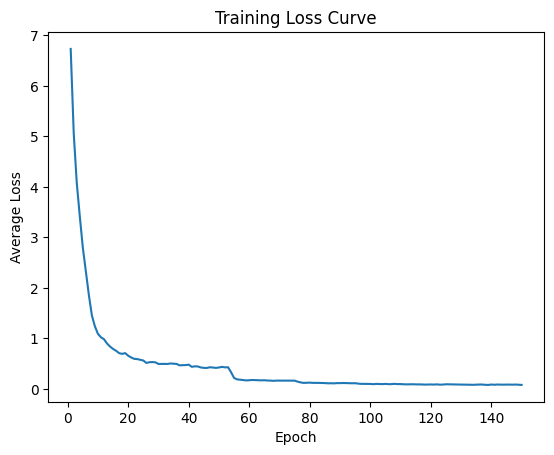

In [17]:
embedding_dim = 128
num_heads = 4
num_blocks = 1
ff_hidden_dim = 64
vocab_size = len(vocab)
best_lr = 0.007266225446794923  # <-- use the best lr here

model = SimpleTransformer(
    vocab_size=vocab_size,
    seq_len=seq_length,
    emb_dim=embedding_dim,
    n_heads=num_heads,
    n_blocks=num_blocks,
    ff_dim=ff_hidden_dim
)

optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)  # <-- set lr here
criterion = nn.CrossEntropyLoss()
causal_mask = generate_causal_mask(seq_length).to(inputs.device)

# ... (your model/optimizer/criterion setup) ...

epochs = 150
print_every = 10
patience = 15  # Number of epochs to wait for improvement before stopping
lr_patience = 7  # Number of epochs to wait before reducing LR
lr_factor = 0.5  # Factor to reduce LR by
min_lr = 1e-5    # Don't reduce below this
best_loss = float('inf')
epochs_no_improve = 0
lr_epochs_no_improve = 0
avg_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in range(inputs.shape[0]):
        inp = inputs[batch]
        tgt = targets[batch]
        optimizer.zero_grad()
        output = model(inp, mask=causal_mask)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / inputs.shape[0]
    avg_losses.append(avg_loss)

    # Print loss
    if (epoch + 1) % print_every == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # Early stopping and LR scheduling
    if avg_loss < best_loss - 1e-4:  # 1e-4 is a small threshold to avoid noise
        best_loss = avg_loss
        epochs_no_improve = 0
        lr_epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        lr_epochs_no_improve += 1

    # Reduce LR on plateau
    if lr_epochs_no_improve >= lr_patience:
        for param_group in optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * lr_factor, min_lr)
            if new_lr < old_lr:
                print(f"Reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")
                param_group['lr'] = new_lr
        lr_epochs_no_improve = 0

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best loss: {best_loss:.4f}")
        break

# Optionally plot the loss curve
import matplotlib.pyplot as plt
plt.plot(range(1, len(avg_losses)+1), avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.show()

## Model Evaluation and Generation

After training, we evaluate the model's ability to generate lyrics. Given a prompt (seed tokens), the model autoregressively predicts subsequent tokens. Sampling temperature can be adjusted to control output diversity.

*Note: While the model may not win a Grammy, it demonstrates the core mechanics of transformer-based text generation.*

In [18]:
import torch.nn.functional as F

def generate(model, start_tokens, word2idx, idx2word, length=50, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([word2idx[token] for token in start_tokens], dtype=torch.long).unsqueeze(0)
    generated = start_tokens.copy()
    for _ in range(length):
        with torch.no_grad():
            mask = generate_causal_mask(input_seq.size(1)).to(input_seq.device)
            output = model(input_seq, mask=mask)
            next_token_logits = output[0, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1).item()
            next_word = idx2word[next_token_id]
            generated.append(next_word)
            input_seq = torch.cat([input_seq, torch.tensor([[next_token_id]])], dim=1)
            if input_seq.size(1) > model.pos_embedding.size(1):
                input_seq = input_seq[:, -model.pos_embedding.size(1):]
    return ' '.join(generated)

# Example usage:
start_tokens = tokens[:5]  # Longer seed for coherence
print("Generated lyrics:")
print(generate(model, start_tokens, word2idx, idx2word, length=20, temperature=1))

Generated lyrics:
i was supposed to be sent away but they forgot to come and get me i was a functioning alcoholic til you get me kill


In [19]:
def preprocess_prompt(prompt, vocab):
    import re
    prompt = prompt.lower()
    prompt = re.sub(r'[^a-z0-9\s]', '', prompt)
    prompt = re.sub(r'\s+', ' ', prompt).strip()
    prompt_tokens = prompt.split()
    # Only keep tokens in vocab
    prompt_tokens = [token for token in prompt_tokens if token in vocab]
    return prompt_tokens

user_prompt = input("Enter your lyric prompt: ")
start_tokens = preprocess_prompt(user_prompt, vocab)
if not start_tokens:
    print("No valid tokens from prompt found in vocabulary.")
else:
    print("Generated lyrics:")
    print(generate(model, start_tokens, word2idx, idx2word, length=20, temperature=0.13))

Generated lyrics:
down bad wavin at the ship fuck it if i cant have him like i lost my twin fuck it if i


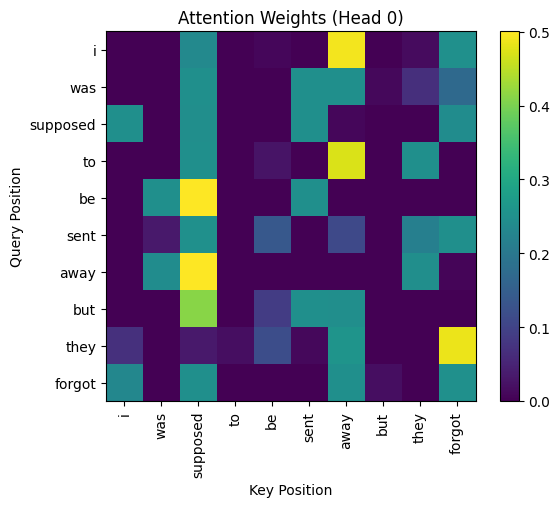

In [20]:
def visualize_attention(model, input_tokens, word2idx, idx2word):
    import matplotlib.pyplot as plt
    input_ids = torch.tensor([word2idx[token] for token in input_tokens], dtype=torch.long).unsqueeze(0)
    encoder_layer = model.transformer.layers[0]
    with torch.no_grad():
        emb = model.embedding(input_ids) + model.pos_embedding[:, :input_ids.size(1), :]
        attn_output, attn_weights = encoder_layer.self_attn(
            emb, emb, emb, need_weights=True, attn_mask=None
        )
    # Try both possible shapes
    attn_weights = attn_weights.cpu().numpy()
    if attn_weights.ndim == 4:
        # (num_heads, batch_size, seq_len, seq_len)
        attn_matrix = attn_weights[0, 0]  # first head, first batch
    elif attn_weights.ndim == 3:
        # (batch_size, seq_len, seq_len)
        attn_matrix = attn_weights[0]     # first batch
    else:
        raise ValueError(f"Unexpected attn_weights shape: {attn_weights.shape}")
    plt.imshow(attn_matrix, cmap='viridis')
    plt.xticks(range(len(input_tokens)), input_tokens, rotation=90)
    plt.yticks(range(len(input_tokens)), input_tokens)
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Attention Weights (Head 0)')
    plt.colorbar()
    plt.show()

# Example usage:
sample_tokens = tokens[:10]
visualize_attention(model, sample_tokens, word2idx, idx2word)

## Model Serialization

For reproducibility and future inference, we serialize both:
- The full model object (`.pth`)
- The model's state dictionary (`state_dict.pth`)

This allows for flexible reloading, either for continued training or deployment.

In [21]:
# Save the entire model
torch.save(model, 'tortured_transformer_model.pth')

# Save only the model's state_dict
torch.save(model.state_dict(), 'tortured_transformer_state_dict.pth')

print("Saved both the full model and the state_dict in the working directory.")

Saved both the full model and the state_dict in the working directory.


# Conclusion

This notebook demonstrates a complete workflow for training a transformer model on a real-world text dataset, with robust engineering practices including data cleaning, batching, early stopping, learning rate scheduling, and hyperparameter optimization. The approach is extensible to other sequence modeling tasks.

*If you made it this far, congratulations-you're the real mastermind.*